In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

pd.options.mode.chained_assignment = None
dataDir = Path.cwd().parent/'CreditCard'
np.random.seed(66)

creditcard = pd.read_csv(dataDir/'creditcard.csv')

In [2]:
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


25691.16    1
19656.53    1
18910.00    1
12910.93    1
11898.09    1
11789.84    1
10199.44    1
10000.00    1
8790.26     1
8787.00     1
Name: Amount, dtype: int64
Distribution of Amount:
 count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


<AxesSubplot:>

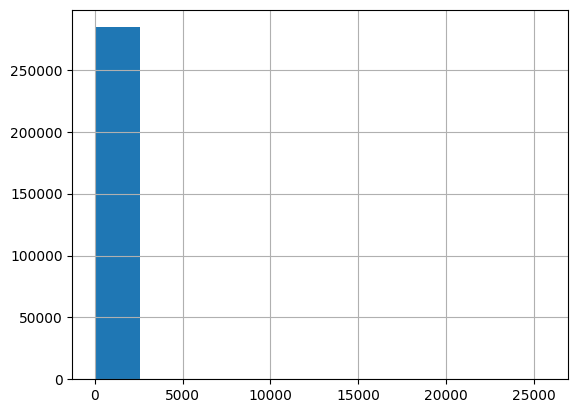

In [3]:
# severe imbalanced dataset
print(creditcard.Amount.value_counts(ascending=True).sort_values(ascending=False).sort_index(ascending=False).head(10))
print("Distribution of Amount:\n", creditcard.Amount.describe())
creditcard.Amount.hist()

### This showcase the outliers exist in the Amount feature, should use RobustScaler here

Distribution:
 0    284315
1       492
Name: Class, dtype: int64
The ratio between minority class and majority class:  0.0017304750013189597


<AxesSubplot:>

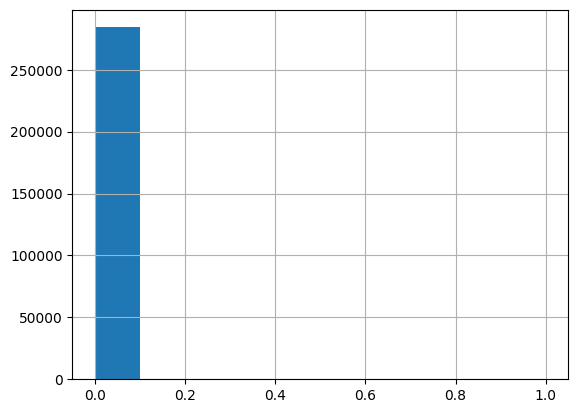

In [4]:
# severe imbalanced dataset
value_counts = creditcard.Class.value_counts()
print("Distribution:\n", value_counts)
print("The ratio between minority class and majority class: ", value_counts[1]/value_counts[0])
creditcard.Class.hist()

### This showcase the dataset is highly imbalanced, should use SMOTE here

In [5]:
""" Feature Engineering """

# Standardize dataset
std_scaler = StandardScaler()
rb_scaler = RobustScaler()

creditcard[["Time"]] = std_scaler.fit_transform(creditcard[["Time"]])
creditcard[["Amount"]] = rb_scaler.fit_transform(creditcard[["Amount"]])

# split features and label
X = creditcard.loc[:, :"Amount"].copy()
y = creditcard.loc[:, "Class"].copy()

# split dataset to training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

# oversampling the train set
sm = SMOTE(sampling_strategy=0.01, random_state=66)
under = RandomUnderSampler(sampling_strategy=0.05)
steps = [('o', sm), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
# X_train_res, y_train_res = X_train, y_train

# move the column Amount to the beginning of the dataframe
cols = X_train_res.columns.tolist()
cols = cols[-1:] + cols[:-1]
X_train_res = X_train_res[cols]
X_train_res.head()

,Amount,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,9.459932,1.224353,-0.722962,-1.374757,-1.257901,-0.562608,-0.799034,0.695132,3.455000,-0.577306,...,-0.325665,1.426791,0.570998,0.571092,1.344495,-0.004072,0.191371,0.675881,-0.465158,-0.192549
1,1.718717,1.052625,-1.882668,0.160697,0.823606,0.006323,0.647234,-0.192066,0.785207,0.480279,...,-0.858501,0.251072,0.629997,1.271304,-0.442771,-0.355695,1.366026,-0.210989,-0.125336,-0.131999
2,1.367149,-0.868826,0.983857,-0.389351,0.749079,0.115997,-0.948208,-0.657622,-0.186278,-0.053817,...,0.132361,0.219093,-0.052205,-0.430284,0.059517,0.603769,-0.067828,0.743801,-0.083422,0.028131
3,1.704744,0.629319,1.800870,-0.039871,-1.944009,1.366597,0.440353,-1.452838,1.031611,-0.591575,...,-0.433957,0.014638,0.209568,0.418787,-0.138671,0.061034,0.430656,-0.502738,-0.056519,-0.038398
4,-0.065675,0.045172,2.074399,0.183331,-2.053540,0.058141,0.826493,-1.048519,0.615110,-0.492990,...,0.181708,-0.191175,0.059291,0.484468,-0.019816,0.774405,0.410009,0.142949,-0.121067,-0.084624


### This plot the distribution of two features V14 and V17 in feature space

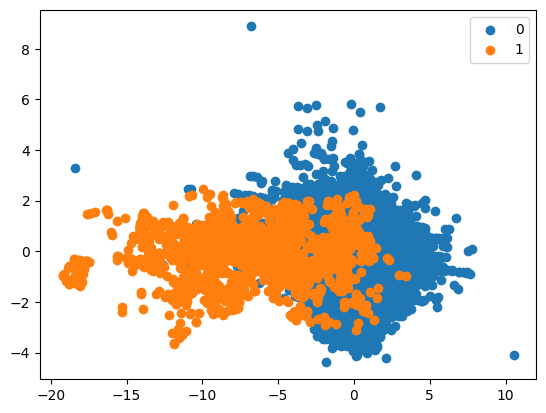

In [6]:
from matplotlib import pyplot
from numpy import where
from collections import Counter

counter = Counter(y_train_res)

X1 = np.array(X_train_res.loc[:, "V14":"V17"])
y1 = np.array(y_train_res)

for label, _ in counter.items():
    row_ix = where(y1 == label)[0]
    pyplot.scatter(X1[row_ix, 0], X1[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [6]:
""" Split dataset into three different data domain """

# Three domains: Digital transaction division, Retail treansaction division, Fraud prevention division
digital_transactrion = X_train_res.loc[:, :'V8'].copy()
retail_transaction = X_train_res.loc[:, 'V9':'V18'].copy()
fraud_prevention = X_train_res.loc[:, 'V19':].copy()

# create three test set based on x_test
digital_transactrion_test = X_test.loc[:, :'V8'].copy()
retail_transaction_test = X_test.loc[:, 'V9':'V18'].copy()
fraud_prevention_test = X_test.loc[:, 'V19':].copy()

# save the dataframes to csv files
# digital_transactrion.to_csv(dataDir/'digital_transaction.csv', index=False)
# retail_transaction.to_csv(dataDir/'retail_transaction.csv', index=False)
# fraud_prevention.to_csv(dataDir/'fraud_prevention.csv', index=False)
# y_train_res.to_csv(dataDir/'label.csv', index=False)

digital_transactrion.head()

,Amount,Time,V1,V2,V3,V4,V5,V6,V7,V8
0,9.459932,1.224353,-0.722962,-1.374757,-1.257901,-0.562608,-0.799034,0.695132,3.455000,-0.577306
1,1.718717,1.052625,-1.882668,0.160697,0.823606,0.006323,0.647234,-0.192066,0.785207,0.480279
2,1.367149,-0.868826,0.983857,-0.389351,0.749079,0.115997,-0.948208,-0.657622,-0.186278,-0.053817
3,1.704744,0.629319,1.800870,-0.039871,-1.944009,1.366597,0.440353,-1.452838,1.031611,-0.591575
4,-0.065675,0.045172,2.074399,0.183331,-2.053540,0.058141,0.826493,-1.048519,0.615110,-0.492990


In [10]:
class CreditCardDataLoader(Dataset):
    """CreditCardDataLoader dataloader for credit card dataset

    Args:
        digitial_transaction (pd.DataFrame): Dataframe of digital transaction records
        retail_transaction (pd.DataFrame): Dataframe of retail transaction records
        fraud_prevention (pd.DataFrame): Dataframe of fraud prevention records
        label (pd.Series): Series of labels
    """
    def __init__(self, digitial_transaction, retail_transaction, fraud_prevention, label):
        self.digitial_transaction = digitial_transaction
        self.retail_transaction = retail_transaction
        self.fraud_prevention = fraud_prevention
        self.label = label
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.digitial_transaction.iloc[idx].values, dtype=torch.float32),
            torch.tensor(self.retail_transaction.iloc[idx].values, dtype=torch.float32),
            torch.tensor(self.fraud_prevention.iloc[idx].values, dtype=torch.float32),
            torch.tensor(self.label.iloc[idx], dtype=torch.float32)
        )

In [13]:
class FraudNN(nn.Module):
    """FraudNN neural network for fraud detection

    Args:
        input_size_1: size of the input of digital transaction division
        input_size_2: size of the input of retail transaction division
        input_size_3: size of the input of fraud prevention division
        hidden_size: size of the hidden layer
        output_size: size of the output layer
        num_hidden_layers: number of hidden layers
    """
    def __init__(
            self,
            input_size: int,
            num_hidden_layers: int = 2,
            hidden_size_1: int = 256,
            hidden_size_2: int = 128,
            output_size: int = 2,
        ):
        super(FraudNN, self).__init__()
        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.output_size = output_size

        if input_size is not None:
            in_channels = (
                [input_size] + 
                [hidden_size_1] * num_hidden_layers +
                [hidden_size_2] +
                [output_size]
            )
        layers = []
        for i in range(len(in_channels)-1):
            layers.append(nn.Linear(in_features=in_channels[i], out_features=in_channels[i+1]))
            if i == 0:
                layers.append(nn.ReLU())
                layers.append(nn.BatchNorm1d(hidden_size_1))
            elif i == len(in_channels)-3:
                layers.append(nn.ReLU())
                layers.append(nn.BatchNorm1d(hidden_size_2))
                layers.append(nn.Dropout(0.2))
            elif i == len(in_channels)-2:
                continue
            else:
                layers.append(nn.ReLU())
                layers.append(nn.BatchNorm1d(hidden_size_1))
                layers.append(nn.Dropout(0.3))
                
        self.layers_stack = nn.Sequential(*layers)


    def forward(self, digital_trans_input, retail_trans_input, fraud_prev_input):

        input = torch.cat([digital_trans_input, retail_trans_input, fraud_prev_input], dim=-1)
        for layer in self.layers_stack:
            input = layer(input)

        return input

def binary_acc(y_pred, y_test):
    acc = 0.0
    
    y_pred_label = torch.softmax(y_pred, dim=1)
    _, y_pred_label = torch.max(y_pred_label, dim = 1)
    correct_pred = (y_pred_label == y_test).sum()
    acc = correct_pred.item()/y_test.shape[0]
    return acc

In [ ]:
learning_rate = 0.003
num_epochs = 100
batch_size = 512

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# set up input size as the sum of the feature of three domains dataset
input_size = digital_transactrion.shape[1] + retail_transaction.shape[1] + fraud_prevention.shape[1]

# create dataloader
dataset = CreditCardDataLoader(digital_transactrion, retail_transaction, fraud_prevention, label=y_train_res)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("test")
# create model
model = FraudNN(input_size=input_size)
model = model.to(device)
print(model)

# create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# create loss function
criterion = nn.CrossEntropyLoss()

# train model
print("Start training...\n")
model.train()
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    epoch_acc = 0.0
    for digital_batch, retail_batch, fraud_batch, label_batch in dataloader:
        digital_batch = digital_batch.to(device)
        retail_batch = retail_batch.to(device)
        fraud_batch = fraud_batch.to(device)
        label_batch = label_batch.to(device)
        optimizer.zero_grad()
        output = model(digital_batch, retail_batch, fraud_batch)
        loss = criterion(output, label_batch.long())
        acc = binary_acc(output, label_batch.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc
    print(f'Epoch {epoch+1} loss: {epoch_loss/len(dataloader):.8f} acc: {epoch_acc/len(dataloader):.4f}')

# save model
torch.save(model.state_dict(), 'fraud_detection.pt')

cuda:0
test
FraudNN(
  (layers_stack): Sequential(
    (0): Linear(in_features=30, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=128, out_features=2, bias=True)
  )
)
Start training...



  0%|          | 0/100 [00:00<?, ?it/s]

In [98]:
torch.save(model.state_dict(), 'fraud_detection.pt')

In [101]:
# load model
device = torch.device("cpu")
model = FraudNN(input_size=input_size)
model.load_state_dict(torch.load('fraud_detection.pt'))
model = model.to(device)


# create test dataset
test_dataset = CreditCardDataLoader(digital_transactrion_test, retail_transaction_test, fraud_prevention_test, label=y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# test model and create confusion matrix
y_pred = []
y_true = []
model.eval()
test_acc = 0.0
with torch.no_grad():
    for digital_batch, retail_batch, fraud_batch, label_batch in test_dataloader:
        digital_batch = digital_batch.to(device)
        retail_batch = retail_batch.to(device)
        fraud_batch = fraud_batch.to(device)
        label_batch = label_batch.to(device)
        output = model(digital_batch, retail_batch, fraud_batch)
        acc = binary_acc(output, label_batch.long())
        test_acc += acc
print(f'Test acc: {test_acc/len(dataloader):.4f}')


# build confusion matrix
y_pred = np.array(y_pred)
y_true = np.array(y_true)
confusion_matrix(y_true, y_pred)


Test acc: 0.3719
